# Bayesian Neural Network (VI) for regression

### Zhenwen Dai (2018-8-21)

In [1]:
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference

/Users/zhenwend/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Generate Synthetic Data

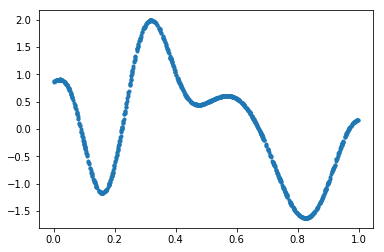

In [2]:
import GPy
%matplotlib inline
from pylab import *

k = GPy.kern.RBF(1, lengthscale=0.1)
x = np.random.rand(1000,1)
y = np.random.multivariate_normal(mean=np.zeros((1000,)), cov=k.K(x), size=(1,)).T
plot(x[:,0], y[:,0], '.')

## Model definition

In [3]:
D = 50
net = nn.HybridSequential(prefix='nn_')
with net.name_scope():
    net.add(nn.Dense(D, activation="tanh"))
    net.add(nn.Dense(D, activation="tanh"))
    net.add(nn.Dense(1, flatten=True))
net.initialize(mx.init.Xavier(magnitude=3))
_=net(mx.nd.array(x))

In [4]:
from mxfusion.components.var_trans import PositiveTransformation
from mxfusion.inference import VariationalPosteriorForwardSampling

In [5]:
m = mf.core.Model()
m.N = mf.components.Variable()
m.f = mf.components.functions.MXFusionGluonFunction(net, nOutputs=1,broadcastable=False)
m.x = mf.components.Variable(shape=(m.N,1))
m.v = mf.components.Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([0.01]))
#m.prior_variance = mf.core.Variable(shape=(1,), transformation=PositiveTransformation())
m.r = m.f(m.x)
for _,v in m.r.factor.block_variables:
    v.set_prior(mf.components.distributions.Normal(mean=mx.nd.array([0]),variance=mx.nd.array([1.])))
m.y = mf.components.distributions.Normal.define_variable(mean=m.r, variance=m.v, shape=(m.N,1))
m.show()

Variable(24825) ~ Normal(mean=Variable(3706e), variance=Variable(78c3f))
Variable(1f4c5) ~ Normal(mean=Variable(d8e05), variance=Variable(b73d6))
Variable(1dbe9) ~ Normal(mean=Variable(6e428), variance=Variable(ee4e8))
Variable(9abb8) ~ Normal(mean=Variable(f8cb1), variance=Variable(73d44))
Variable(cdf2a) ~ Normal(mean=Variable(b4c6f), variance=Variable(5f593))
Variable(e28f4) ~ Normal(mean=Variable(528e0), variance=Variable(c17f7))
r = GluonFunctionEvaluation(nn_dense0_weight=Variable(e28f4), nn_dense0_bias=Variable(cdf2a), nn_dense1_weight=Variable(9abb8), nn_dense1_bias=Variable(1dbe9), nn_dense2_weight=Variable(1f4c5), nn_dense2_bias=Variable(24825), nn_input_0=x)
y ~ Normal(mean=r, variance=v)


## Inference with Meanfield

In [7]:
from mxfusion.inference import BatchInferenceLoop, create_Gaussian_meanfield, GradBasedInference, StochasticVariationalInference

In [9]:
observed = [m.y, m.x]
q = create_Gaussian_meanfield(model=m, observed=observed)
alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [10]:
infr.initialize(y=mx.nd.array(y), x=mx.nd.array(x))

 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/inference/inference_parameters.py:52: UserWarning:InferenceParameters has already been initialized.  The existing one will be overwritten.


In [13]:
for v_name, v in m.r.factor.block_variables:
    uuid = v.uuid
    loc_uuid = infr.inference_algorithm.posterior[uuid].factor.variance.uuid
    a = infr.params.param_dict[loc_uuid].data().asnumpy()
    a[:] = 1e-6
    infr.params[infr.inference_algorithm.posterior[uuid].factor.mean] = net.collect_params()[v_name].data()
    infr.params[infr.inference_algorithm.posterior[uuid].factor.variance] = mx.nd.array(a)

In [14]:
infr.run(max_iter=2000, learning_rate=1e-2, y=mx.nd.array(y), x=mx.nd.array(x), verbose=True)

 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/inference/inference.py:111: UserWarning:Trying to initialize the inference twice, skipping.


Iteration 1 logL: -18724.296875
Iteration 2 logL: -18879.15234375
Iteration 3 logL: -18698.25390625
Iteration 4 logL: -18668.005859375
Iteration 5 logL: -18671.970703125
Iteration 6 logL: -18630.625
Iteration 7 logL: -18567.974609375
Iteration 8 logL: -18527.23828125
Iteration 9 logL: -18513.171875
Iteration 10 logL: -18510.267578125
Iteration 11 logL: -18485.630859375
Iteration 12 logL: -18485.716796875
Iteration 13 logL: -18449.76171875
Iteration 14 logL: -18451.197265625
Iteration 15 logL: -18420.908203125
Iteration 16 logL: -18443.97265625
Iteration 17 logL: -18436.333984375
Iteration 18 logL: -18369.080078125
Iteration 19 logL: -18323.1171875
Iteration 20 logL: -18373.0546875
Iteration 21 logL: -18356.80078125
Iteration 22 logL: -18305.6015625
Iteration 23 logL: -18291.322265625
Iteration 24 logL: -18300.39453125
Iteration 25 logL: -18290.212890625
Iteration 26 logL: -18276.2734375
Iteration 27 logL: -18230.921875
Iteration 28 logL: -18253.62109375
Iteration 29 logL: -18226.800781

Iteration 234 logL: -15404.48046875
Iteration 235 logL: -15434.705078125
Iteration 236 logL: -15392.3662109375
Iteration 237 logL: -15370.064453125
Iteration 238 logL: -15381.0703125
Iteration 239 logL: -15363.296875
Iteration 240 logL: -15302.9853515625
Iteration 241 logL: -15333.3662109375
Iteration 242 logL: -15291.2158203125
Iteration 243 logL: -15268.6103515625
Iteration 244 logL: -15222.4453125
Iteration 245 logL: -15184.7666015625
Iteration 246 logL: -15210.71484375
Iteration 247 logL: -15176.96875
Iteration 248 logL: -15098.1201171875
Iteration 249 logL: -15127.9873046875
Iteration 250 logL: -15105.546875
Iteration 251 logL: -15101.3056640625
Iteration 252 logL: -15055.7470703125
Iteration 253 logL: -15006.4853515625
Iteration 254 logL: -15020.3115234375
Iteration 255 logL: -14973.791015625
Iteration 256 logL: -14951.224609375
Iteration 257 logL: -14918.6015625
Iteration 258 logL: -14914.896484375
Iteration 259 logL: -14910.78515625
Iteration 260 logL: -14870.5048828125
Iterati

Iteration 460 logL: -12086.60546875
Iteration 461 logL: -12035.1630859375
Iteration 462 logL: -12037.7109375
Iteration 463 logL: -12021.326171875
Iteration 464 logL: -11985.955078125
Iteration 465 logL: -11957.1865234375
Iteration 466 logL: -11995.3720703125
Iteration 467 logL: -11987.763671875
Iteration 468 logL: -11944.2412109375
Iteration 469 logL: -11955.6025390625
Iteration 470 logL: -11907.923828125
Iteration 471 logL: -11899.19140625
Iteration 472 logL: -11902.8916015625
Iteration 473 logL: -11851.23828125
Iteration 474 logL: -11881.828125
Iteration 475 logL: -11845.001953125
Iteration 476 logL: -11847.9765625
Iteration 477 logL: -11839.4658203125
Iteration 478 logL: -11865.8076171875
Iteration 479 logL: -11792.619140625
Iteration 480 logL: -11792.583984375
Iteration 481 logL: -11756.107421875
Iteration 482 logL: -11794.072265625
Iteration 483 logL: -11759.0078125
Iteration 484 logL: -11708.3642578125
Iteration 485 logL: -11745.6328125
Iteration 486 logL: -11721.7900390625
Itera

Iteration 690 logL: -8963.421875
Iteration 691 logL: -8984.2265625
Iteration 692 logL: -8943.1953125
Iteration 693 logL: -8918.7822265625
Iteration 694 logL: -8964.2978515625
Iteration 695 logL: -8906.81640625
Iteration 696 logL: -8910.5419921875
Iteration 697 logL: -8926.953125
Iteration 698 logL: -8921.685546875
Iteration 699 logL: -8878.154296875
Iteration 700 logL: -8839.798828125
Iteration 701 logL: -8859.958984375
Iteration 702 logL: -8786.5087890625
Iteration 703 logL: -8824.2568359375
Iteration 704 logL: -8824.8349609375
Iteration 705 logL: -8788.0986328125
Iteration 706 logL: -8800.716796875
Iteration 707 logL: -8746.3515625
Iteration 708 logL: -8755.919921875
Iteration 709 logL: -8762.5986328125
Iteration 710 logL: -8706.1494140625
Iteration 711 logL: -8727.3046875
Iteration 712 logL: -8653.17578125
Iteration 713 logL: -8668.775390625
Iteration 714 logL: -8680.857421875
Iteration 715 logL: -8690.7734375
Iteration 716 logL: -8638.8505859375
Iteration 717 logL: -8623.494140625


Iteration 917 logL: -5772.6005859375
Iteration 918 logL: -6065.7646484375
Iteration 919 logL: -6123.12158203125
Iteration 920 logL: -5810.6298828125
Iteration 921 logL: -5651.958984375
Iteration 922 logL: -5878.81689453125
Iteration 923 logL: -6384.916015625
Iteration 924 logL: -5783.3564453125
Iteration 925 logL: -5630.8798828125
Iteration 926 logL: -5804.8818359375
Iteration 927 logL: -5720.53955078125
Iteration 928 logL: -6159.7958984375
Iteration 929 logL: -5737.958984375
Iteration 930 logL: -5582.4921875
Iteration 931 logL: -5546.17333984375
Iteration 932 logL: -5753.5771484375
Iteration 933 logL: -5701.69921875
Iteration 934 logL: -5619.6630859375
Iteration 935 logL: -5631.33203125
Iteration 936 logL: -5472.2021484375
Iteration 937 logL: -5567.48828125
Iteration 938 logL: -5637.1376953125
Iteration 939 logL: -5596.400390625
Iteration 940 logL: -5696.048828125
Iteration 941 logL: -5428.2578125
Iteration 942 logL: -5435.07177734375
Iteration 943 logL: -5649.953125
Iteration 944 log

Iteration 1138 logL: -3384.003173828125
Iteration 1139 logL: -3106.176025390625
Iteration 1140 logL: -3244.28466796875
Iteration 1141 logL: -3295.09765625
Iteration 1142 logL: -3373.354736328125
Iteration 1143 logL: -3604.62158203125
Iteration 1144 logL: -2997.947021484375
Iteration 1145 logL: -3138.3828125
Iteration 1146 logL: -3470.816650390625
Iteration 1147 logL: -3404.827880859375
Iteration 1148 logL: -3152.863525390625
Iteration 1149 logL: -3132.96142578125
Iteration 1150 logL: -3394.03564453125
Iteration 1151 logL: -3419.419677734375
Iteration 1152 logL: -3118.311279296875
Iteration 1153 logL: -3702.74951171875
Iteration 1154 logL: -3494.944091796875
Iteration 1155 logL: -2969.537841796875
Iteration 1156 logL: -3136.345703125
Iteration 1157 logL: -3167.41162109375
Iteration 1158 logL: -3357.986083984375
Iteration 1159 logL: -3184.684326171875
Iteration 1160 logL: -3088.1298828125
Iteration 1161 logL: -2873.75634765625
Iteration 1162 logL: -3251.76123046875
Iteration 1163 logL: -

Iteration 1348 logL: -2014.4932861328125
Iteration 1349 logL: -2338.93408203125
Iteration 1350 logL: -2150.32421875
Iteration 1351 logL: -1841.7650146484375
Iteration 1352 logL: -1846.023681640625
Iteration 1353 logL: -1997.0467529296875
Iteration 1354 logL: -2061.569091796875
Iteration 1355 logL: -2134.61865234375
Iteration 1356 logL: -1864.1640625
Iteration 1357 logL: -2076.2958984375
Iteration 1358 logL: -1975.04345703125
Iteration 1359 logL: -2155.977783203125
Iteration 1360 logL: -2397.01513671875
Iteration 1361 logL: -2151.866943359375
Iteration 1362 logL: -2528.355712890625
Iteration 1363 logL: -1940.532958984375
Iteration 1364 logL: -1806.6131591796875
Iteration 1365 logL: -2124.21142578125
Iteration 1366 logL: -2439.08056640625
Iteration 1367 logL: -2179.723388671875
Iteration 1368 logL: -2853.701171875
Iteration 1369 logL: -1885.2803955078125
Iteration 1370 logL: -2280.45751953125
Iteration 1371 logL: -1804.5162353515625
Iteration 1372 logL: -2049.10009765625
Iteration 1373 l

Iteration 1554 logL: -1513.0421142578125
Iteration 1555 logL: -1532.954345703125
Iteration 1556 logL: -1267.11962890625
Iteration 1557 logL: -1336.03125
Iteration 1558 logL: -1526.9178466796875
Iteration 1559 logL: -1216.7047119140625
Iteration 1560 logL: -1521.1041259765625
Iteration 1561 logL: -1942.0791015625
Iteration 1562 logL: -1336.9322509765625
Iteration 1563 logL: -1308.4619140625
Iteration 1564 logL: -1560.1959228515625
Iteration 1565 logL: -1554.3807373046875
Iteration 1566 logL: -1589.8492431640625
Iteration 1567 logL: -1712.0570068359375
Iteration 1568 logL: -1706.903076171875
Iteration 1569 logL: -1190.98583984375
Iteration 1570 logL: -1395.9580078125
Iteration 1571 logL: -1625.474365234375
Iteration 1572 logL: -1618.5718994140625
Iteration 1573 logL: -1234.91064453125
Iteration 1574 logL: -1581.50244140625
Iteration 1575 logL: -1373.535888671875
Iteration 1576 logL: -1417.5321044921875
Iteration 1577 logL: -1356.541015625
Iteration 1578 logL: -1387.89794921875
Iteration 

Iteration 1765 logL: -1246.945068359375
Iteration 1766 logL: -1039.462890625
Iteration 1767 logL: -1142.111572265625
Iteration 1768 logL: -1265.45654296875
Iteration 1769 logL: -1281.721923828125
Iteration 1770 logL: -1309.653564453125
Iteration 1771 logL: -1680.562255859375
Iteration 1772 logL: -1293.718994140625
Iteration 1773 logL: -865.4189453125
Iteration 1774 logL: -1144.5948486328125
Iteration 1775 logL: -1170.566162109375
Iteration 1776 logL: -1996.01025390625
Iteration 1777 logL: -1267.449462890625
Iteration 1778 logL: -1196.176025390625
Iteration 1779 logL: -1323.94482421875
Iteration 1780 logL: -1565.8349609375
Iteration 1781 logL: -1299.803955078125
Iteration 1782 logL: -1372.863525390625
Iteration 1783 logL: -1746.3642578125
Iteration 1784 logL: -1097.82568359375
Iteration 1785 logL: -1432.067138671875
Iteration 1786 logL: -1337.90478515625
Iteration 1787 logL: -1412.645751953125
Iteration 1788 logL: -1321.851806640625
Iteration 1789 logL: -1345.647216796875
Iteration 1790

Iteration 1976 logL: -1086.295166015625
Iteration 1977 logL: -902.845703125
Iteration 1978 logL: -1262.313232421875
Iteration 1979 logL: -1039.027587890625
Iteration 1980 logL: -892.798095703125
Iteration 1981 logL: -943.1220703125
Iteration 1982 logL: -1156.06591796875
Iteration 1983 logL: -1353.580078125
Iteration 1984 logL: -856.92529296875
Iteration 1985 logL: -1020.078857421875
Iteration 1986 logL: -1095.52685546875
Iteration 1987 logL: -1237.697265625
Iteration 1988 logL: -998.10693359375
Iteration 1989 logL: -1152.889892578125
Iteration 1990 logL: -963.375732421875
Iteration 1991 logL: -925.7431640625
Iteration 1992 logL: -906.114013671875
Iteration 1993 logL: -1085.943359375
Iteration 1994 logL: -1247.585693359375
Iteration 1995 logL: -931.400146484375
Iteration 1996 logL: -993.2607421875
Iteration 1997 logL: -1423.531005859375
Iteration 1998 logL: -968.134521484375
Iteration 1999 logL: -927.2412109375
Iteration 2000 logL: -987.966064453125


## Use prediction to visualize the resulting BNN

In [15]:
xt = np.linspace(0,1,100)[:,None]

In [16]:
infr2 = VariationalPosteriorForwardSampling(10, [m.x], infr, [m.r])
res = infr2.run(x=mx.nd.array(xt))

 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/core/factor_graph.py:65: UserWarning:The value N has already been assigned in the model.
 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/core/factor_graph.py:65: UserWarning:The value y has already been assigned in the model.
 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/inference/inference_parameters.py:52: UserWarning:InferenceParameters has already been initialized.  The existing one will be overwritten.


In [17]:
yt = res[m.r].asnumpy()

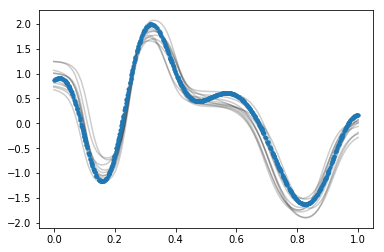

In [18]:
# plot(xt[:,0],yt[:,0])
yt_mean = yt.mean(0)
yt_std = yt.std(0)
#plot(xt[:,0], yt.mean(0)[:,0])
#errorbar(xt[:,0],y=yt_mean[:,0],yerr=yt_std[:,0]*2)
for i in range(yt.shape[0]):
    plot(xt[:,0],yt[i,:,0],'k',alpha=0.2)
plot(x[:,0],y[:,0],'.')